### **Langkah-langkah**
1. Import semua library
2. Masukkan data yang telah di-clean
3. Menganalisis persebaran label di training data
4. Feature Extraction dengan tf-idf
5. Handling Imbalance dengan SMOTE Oversampling
6. Modelling
7. Melihat Feature/kata yang penting dalam pembuatan model
8. Pembuatan file hasil akhir dan download.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

# Input Data
Data yang diinput disini telah di-clean menggunakan program Data Pre-processing NLP, sehingga tidak ada kata-kata yang duplikat. 

In [2]:
train = pd.read_csv("https://drive.google.com/uc?id=1TBvTx7PFoMxZtJcZLan8hvT0QeP1M3Ui")

In [3]:
train.head()

,filename,label,text
0,3533,2,execve ioctl prctl time getpid fork wait4 SIGC...
1,1270,5,execve uname brk set_tls set_tid_address set_r...
2,3270,1,execve brk set_tls ioctl access geteuid32 prct...
3,1323,2,execve ioctl unlink time getpid getppid times ...
4,1064,2,execve ioctl time getpid socket connect getsoc...


In [4]:
test = pd.read_csv("https://drive.google.com/uc?id=1Oaer0ArmLd3xi0G3g_2rAkeOVHjaaSXQ")
test.head()

,filename,text
0,54,execve mmap2 cacheflush readlink mprotect brk ...
1,1460,execve brk set_tls ioctl rt_sigprocmask rt_sig...
2,1312,execve ioctl time getpid socket connect getsoc...
3,1230,execve ioctl time getpid socket connect getsoc...
4,3077,execve brk set_tls ioctl gettimeofday getpid s...


# Melihat Sebaran Label pada Data Train
Dapat dilihat bahwa data ini imbalanced. Malware tipe 2 dan 1 jumlahnya jauh melebihi jumlah tipe  5, 4, dan 3 yang sangat sedikit. 

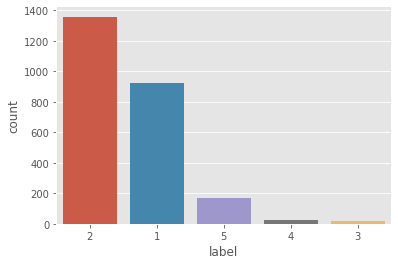

In [5]:
import seaborn as sns
sns.countplot(x ='label', data = train,order = train["label"].value_counts().index)
 
# Show the plot
plt.show()

Dikarenakan data imbalance, kita akan menggunakan SMOTE oversampling dalam pemodelan.

# Feature Extraction dengan Tfidf


In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')

# We transform each text into a vector
features_train = tfidf.fit_transform(train.text).toarray()
features_test = tfidf.transform(test.text).toarray()

features_train_name = tfidf.get_feature_names()

labels = train.label

print("Jumlah Feature")
print(features_train.shape[1])

Jumlah Feature
107


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
features_train

array([[0.        , 0.15066684, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10297091,
        0.20765061],
       [0.        , 0.11054383, 0.28549065, ..., 0.        , 0.16787606,
        0.        ],
       ...,
       [0.        , 0.06451821, 0.        , ..., 0.        , 0.09797981,
        0.19758559],
       [0.        , 0.06451821, 0.        , ..., 0.        , 0.09797981,
        0.19758559],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10297091,
        0.20765061]])

# Handling Imbalance dengan SMOTE Oversampling

In [7]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
features_train, labels = oversample.fit_resample(features_train, labels)

# Modelling
Disini kita akan melakukan:

1. mengimport algoritma machine learning
2. mencoba setiap algoritma tersebut dengan 5-fold cross validation
3. memilih algoritma terbaik dengan melihat F1-score terbaik. 
4. menggunakan algoritma terbaik tersebut untuk memprediksi label test data. 

In [8]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
#mencoba beberapa algoritma machine learning

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),XGBClassifier()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features_train, labels, scoring='f1_macro', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_macro'])

In [10]:
mean_accuracy = cv_df.groupby('model_name').f1_macro.mean()
std_accuracy = cv_df.groupby('model_name').f1_macro.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean F1_Macro', 'Standard deviation']
acc

,Mean F1_Macro,Standard deviation
model_name,,
LinearSVC,0.986446,0.003058
MultinomialNB,0.954263,0.005591
RandomForestClassifier,0.972305,0.004489
XGBClassifier,0.990424,0.002944


Kita akan menggunakan XGBClassifier karena mempunyai skor F1_Macro yang paling besar

In [11]:
xgb_model = XGBClassifier()
xgb_model.fit(features_train,labels)
labels_test = xgb_model.predict(features_test)


# Melihat Feature (dalam kasus ini kata) yang Penting dalam Pemodelan

Semakin Important suatu kata, semakin berpengaruh kata tersebut dalam membantu klasifikasi. 

Text(0.5, 1.0, 'Top 10 Feature Importances XGBoost Classifier')

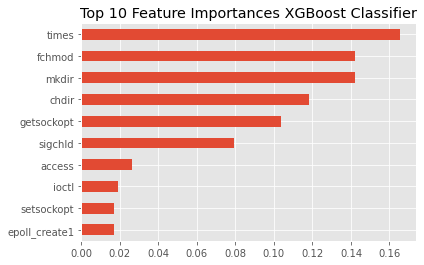

In [12]:
importance = pd.Series(xgb_model.feature_importances_, index=features_train_name).sort_values(ascending=True)
importance = importance.tail(10)
importance.plot(kind='barh')
plt.title('Top 10 Feature Importances XGBoost Classifier')

# Submisi dan Download

Langkah yang dilakukan adalah:

1. membuat dataframe berisi nama file sequence (dari data test) serta labelnya (yang telah predicted)
2. membuat csv dari dataframe tersebut

In [13]:
submission = pd.DataFrame({
    "filename": test.filename,
    "label": labels_test
    })
submission.to_csv("444070_446785_test.csv", index=False)

In [14]:
from google.colab import files
files.download("444070_446785_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Kesimpulan

Model terbaik dalam melakukan klasifikasi malware dari text LOG pada IoT adalah **XGBoost Classifier dengan nilai rata-rata f1_score macro +0.99**

5 kata terpenting dalam klasifikasi malware dari text LOG pada IoT adalah 


1. Times
2. fchmod
3. mkdir
4. getsockopt
5. chdir

